# Introduction

From the [PVSC44 TL sensitivity](PVSC44%20TL%20sensitivity.ipynb) we concluded that:
    
* Overal MACC data is higher than corresponding static or optimized $T_L$ which leads to low dyanamic predictions.
* For at least 3 SURFRAD stations: bon, psu and sxf high $T_L$ in summer caused a seasonal bias in GHI predictions.
* For the high elevation stations: tbl and dra, that also have very high DNI and low DHI, optimization of $T_L$ led
  to unphysical values, indicating that another factor may, such as sensor error, may be affecting predictions more than
  atmospheric conditions.
  
    In Ineichen's review paper [Ineichen, 2016], underestimation of all models was also attributed to MACC AOD values. Therefore, we attempt to scale the ECMWF AOD data with the static $T_L$ values to reduce the error, but allow the real-time data to be used with the Simplified Solis and Bird models that don't use $T_L$

## References
Ineihen, Pierre, "Validation of Models that Estimate Clear Sky Global and Beam Solar Irradiance", _Solar Energy_ 2016 DOI: 10.1016/j.solener.2016.03.017

In [1]:
# imports and settings
import os

import h5py
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pvlib
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import minimize_scalar

from pvsc44_clearsky_aod import ecmwf_macc_tools

%matplotlib inline

sns.set_context('notebook', rc={'figure.figsize': (8, 6)})
sns.set(font_scale=1.5)

c:\python27\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# get the "metadata" that contains the station id codes for the SURFRAD data that was analyzed
METADATA = pd.read_csv('metadata.csv', index_col=0)

In [3]:
# load calculations for each station
atm_params_3min_clear = {}
for station_id in METADATA.index:
    with h5py.File('%s_3min_clear_atm_params.h5' % station_id, 'r') as f:
        np_atm_params_3min_clear = pd.DataFrame(np.array(f['data']))
    np_atm_params_3min_clear['index'] = pd.DatetimeIndex(np_atm_params_3min_clear['index'])
    np_atm_params_3min_clear.set_index('index', inplace=True)
    np_atm_params_3min_clear.index.rename('timestamps', inplace=True)
    atm_params_3min_clear[station_id] = np_atm_params_3min_clear

In [4]:
# filter out low light

# CONSTANTS
MODELS = {'solis': 'SOLIS', 'lt': 'Linke', 'macc': 'ECMWF-MACC', 'bird': 'Bird'}
CS = ['dni', 'dhi', 'ghi']
LOW_LIGHT = 200  # threshold for low light in W/m^2

is_bright = {}
for station_id, station_atm_params_3min_clear in atm_params_3min_clear.iteritems():
    is_bright[station_id] = station_atm_params_3min_clear['ghi'] > LOW_LIGHT

In [23]:
TL_SENS = pd.read_csv('TL_sensitivity.csv')
TL_SENS

,Unnamed: 0,station,lt_opt,lt_ref,month,count,mbe_ghi,mbe_dni,mbe_dhi,opt_mbe_ghi,opt_mbe_dni,opt_mbe_dhi
0,0,bon,2.155085,2.355085,1,9129,-0.001547,0.019818,-0.233246,-0.019473,0.061968,-0.382488
1,1,bon,1.905000,2.655000,2,10781,-0.028635,-0.019283,-0.245600,0.003184,0.124124,-0.564924
2,2,bon,2.618238,2.955738,3,11380,-0.019267,0.000922,-0.124920,0.000631,0.047036,-0.256759
3,3,bon,2.805533,3.318033,4,16840,-0.034489,-0.037388,-0.039750,-0.000314,0.040061,-0.217297
4,4,bon,3.352459,4.352459,5,15367,-0.070550,-0.122929,0.137035,0.002310,0.003648,-0.076593
5,5,bon,3.496721,4.296721,6,17690,-0.061441,-0.109276,0.128928,0.001760,-0.005993,-0.051460
6,6,bon,3.807661,4.120161,7,19582,-0.037252,-0.056119,0.018070,-0.000327,-0.009347,-0.048644
7,7,bon,3.337705,4.137705,8,20634,-0.047119,-0.082604,0.017053,0.011332,0.023445,-0.181495
8,8,bon,3.121107,4.083607,9,20904,-0.053420,-0.113659,0.135163,-0.000736,0.004077,-0.122976
9,9,bon,2.892623,3.092623,10,17870,-0.023206,-0.075064,0.124854,-0.013717,-0.036153,-0.016330


For each station, find the AOD scaling factor that makes the 2003 $T_L$ calculated equivalient to the static $T_L$ values.

So I did that, but in the process I made a funny discovery - the MACC AOD only results in higher $T_L$ if you include low irradiance. But, if you filter out low light conditions, then the MACC AOD calculated $T_L$ actually matches the historical values well.

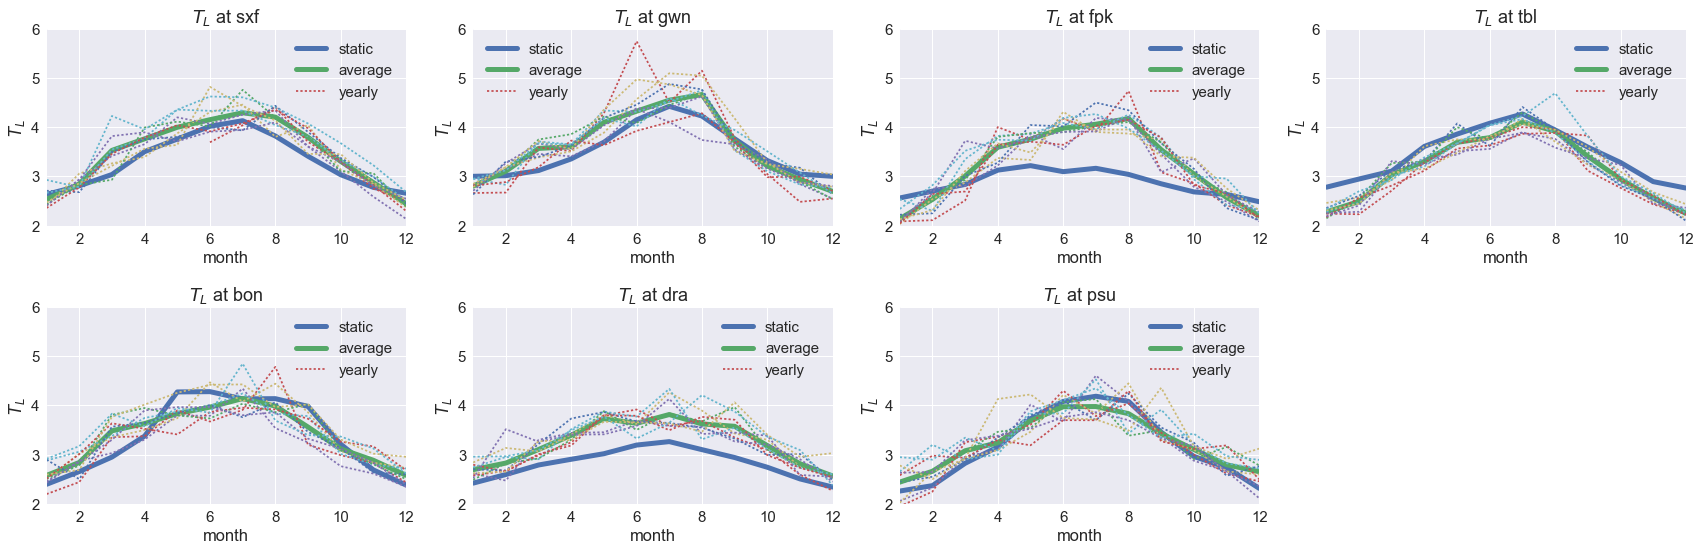

In [24]:
# compare historic Linke turbidity to calculated
# downsample to monthly averages to show long term trends
f, ax = plt.subplots(2, 4, figsize=(24, 8), sharex=False)
rc = 0
for station_id, station_atm_params_3min_clear in atm_params_3min_clear.iteritems():
    r, c = rc // 4, rc % 4
    station_tl = station_atm_params_3min_clear[['lt', 'lt_calc']][is_bright[station_id]]
    station_tl['lt'].groupby(lambda x: x.month).mean().plot(linewidth=5, ax=ax[r][c])
    station_tl['lt_calc'].groupby(lambda x: x.month).mean().plot(linewidth=5, ax=ax[r][c])
    for y in xrange(2003, 2013):
        lt = station_tl['lt_calc'][('%d-01-01 00:00:00' % y):('%d-12-31 23:59:59' % y)].groupby(lambda x: x.month).mean()
        lt.plot(linestyle=':', ax=ax[r][c])
    ax[r][c].set_ylabel('$T_L$')
    ax[r][c].set_xlabel('month')
    ax[r][c].legend(['static', 'average', 'yearly'])
    ax[r][c].set_title('$T_L$ at %s' % station_id)
    ax[r][c].set_ylim([2, 6])
    rc += 1
ax[1][3].axis('off')
f.tight_layout()
plt.savefig('Linke_turbidity_allyears_monthly.png')

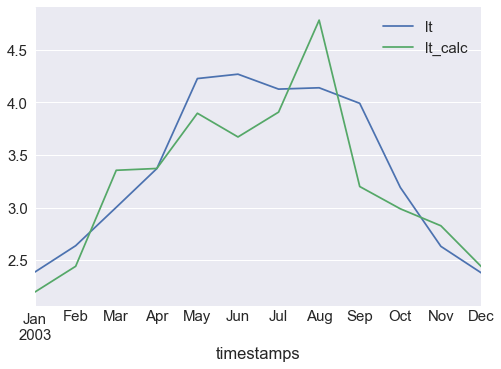

In [40]:
bon2003 = atm_params_3min_clear['bon'][['lt', 'lt_calc']][is_bright['bon']]['2003-01-01 00:00:00':'2003-12-31 23:59:59']
monthly_2003_tl = bon2003.resample('M').mean()
monthly_2003_tl.plot()

In [41]:
mean_2003_tl = monthly_2003_tl.mean()
mean_2003_tl['lt']/mean_2003_tl['lt_calc']

1.0326089681953619

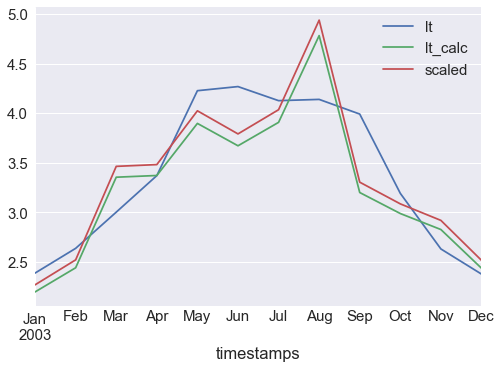

In [42]:
monthly_2003_tl['scaled'] = monthly_2003_tl['lt_calc']*mean_2003_tl['lt']/mean_2003_tl['lt_calc']
monthly_2003_tl.plot()

In [43]:
mean_monthly_2003_tl = monthly_2003_tl['lt'] / monthly_2003_tl['lt_calc']
mean_monthly_2003_tl

timestamps
2003-01-31    1.086539
2003-02-28    1.080151
2003-03-31    0.894980
2003-04-30    0.999688
2003-05-31    1.084635
2003-06-30    1.162586
2003-07-31    1.056009
2003-08-31    0.865479
2003-09-30    1.247196
2003-10-31    1.068039
2003-11-30    0.930753
2003-12-31    0.975713
Freq: M, dtype: float64

In [44]:
atm_params_2003 = atm_params_3min_clear['bon'][['amp', 'pwat', 'tau700', 'lt']][is_bright['bon']]['2003-01-01 00:00:00':'2003-12-31 23:59:59']
def _poop(x, amp=atm_params_2003['amp'], pwat=atm_params_2003['pwat'], bbaod=atm_params_2003['tau700']):
    lt_calc = pvlib.atmosphere.kasten96_lt(amp, pwat, (x * bbaod))
    lt_calc_monthly = lt_calc.resample('M').mean()
    lt_monthly = atm_params_2003['lt'].resample('M').mean()
    return np.sum((lt_calc_monthly - lt_monthly)**2)
res = minimize_scalar(_poop)
res

     fun: 1.8152619564883925
    nfev: 6
     nit: 5
 success: True
       x: 1.0353899410064087

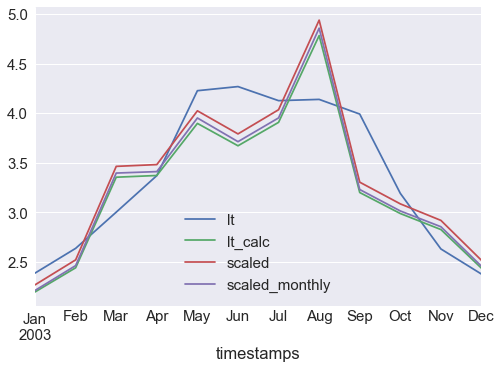

In [45]:
monthly_2003_tl['scaled_monthly'] = pvlib.atmosphere.kasten96_lt(atm_params_2003['amp'], atm_params_2003['pwat'], res['x']*atm_params_2003['tau700']).resample('M').mean()
monthly_2003_tl.plot()

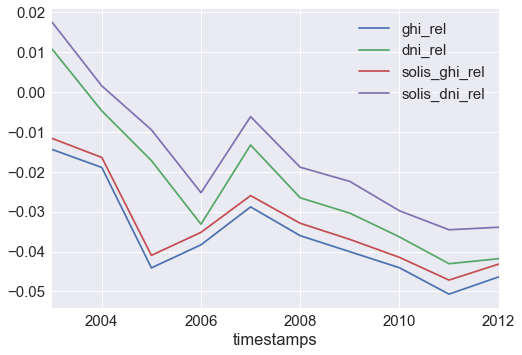

In [46]:
 solis_scaled = pvlib.clearsky.simplified_solis(
    atm_params_3min_clear['bon']['apparent_elevation'],
    atm_params_3min_clear['bon']['tau700']*res['x'],
    atm_params_3min_clear['bon']['pwat'],
    pressure=atm_params_3min_clear['bon']['press'],
    dni_extra=atm_params_3min_clear['bon']['etr']
)
solis_scaled.rename(columns={'ghi': 'scaled_ghi', 'dni': 'scaled_dni', 'dhi': 'scaled_dhi'}, inplace=True)
solis_scaled = pd.concat([solis_scaled, atm_params_3min_clear['bon'][['solis_ghi', 'solis_dni', 'solis_dhi', 'ghi', 'dni', 'dhi']]], axis=1)
solis_scaled['solis_ghi_err'] = solis_scaled['solis_ghi'] - solis_scaled['ghi']
solis_scaled['solis_dni_err'] = solis_scaled['solis_dni'] - solis_scaled['dni']
solis_scaled['solis_dhi_err'] = solis_scaled['solis_dhi'] - solis_scaled['dhi']
solis_scaled['ghi_err'] = solis_scaled['scaled_ghi'] - solis_scaled['ghi']
solis_scaled['dni_err'] = solis_scaled['scaled_dni'] - solis_scaled['dni']
solis_scaled['dhi_err'] = solis_scaled['scaled_dhi'] - solis_scaled['dhi']
solis_scaled['ghi_norm'] = solis_scaled['ghi_err']**2
solis_scaled['dni_norm'] = solis_scaled['dni_err']**2
solis_scaled['dhi_norm'] = solis_scaled['dhi_err']**2
solis_scaled_annual = solis_scaled.resample('A').mean()
solis_scaled_annual['ghi_rel'] = solis_scaled_annual['ghi_err'] / solis_scaled_annual['ghi']
solis_scaled_annual['dni_rel'] = solis_scaled_annual['dni_err'] / solis_scaled_annual['dni']
solis_scaled_annual['dhi_rel'] = solis_scaled_annual['dhi_err'] / solis_scaled_annual['dhi']
solis_scaled_annual['solis_ghi_rel'] = solis_scaled_annual['solis_ghi_err'] / solis_scaled_annual['ghi']
solis_scaled_annual['solis_dni_rel'] = solis_scaled_annual['solis_dni_err'] / solis_scaled_annual['dni']
solis_scaled_annual['solis_dhi_rel'] = solis_scaled_annual['solis_dhi_err'] / solis_scaled_annual['dhi']
solis_scaled_annual[['ghi_rel', 'dni_rel', 'solis_ghi_rel', 'solis_dni_rel']].plot()

So, as it turns out, scaling the MACC AOD isn't necessary, or at least the magnitude of MACC AOD isn't an issue. And it doesn't seem to be too high.